# Paramteridentifikation

## Least Squares Schätzer

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

$$

L_{a} \frac{\partial}{\partial t} i_{a} = u_{a} - R_{a} i_{a} - k_{a} \omega   \\

J_{r} \frac{\partial}{\partial t} \omega = k_{a} i_{a} - d_{v} \omega - d_{c} sign(\omega)
$$

mit der allgemeinen Lösung

$$
x = (A^{T}A)^{-1}A^{T}y
$$


damit ergibt sich 





$$
R_{a} = 1.379 \Omega \\
k_{a} = 0.0652 \frac{V s}{rad} \\
d_{c} = 0.0188 Nm \\
d_{v} = 43.3 · 10−6  \frac{N m s}{rad}
$$


und Allgmein mit den Matrixen

$$
Ax = y   \\
\begin{bmatrix}
i & -\omega & 0 & 0   \\
i & 0 & sign(\omega) & -\omega
\end{bmatrix}

\begin{bmatrix}
R \\ k \\ d_{c} \\ d_{v}
\end{bmatrix}
=
\begin{bmatrix}
u_{a} & 0
\end{bmatrix}

$$


In [ ]:
import scipy.io
from scipy.optimize import leastsq
from scipy import signal
import matplotlib.pyplot as plt
import time
start = time.time()

# Einlesen der Daten
data = scipy.io.loadmat("Identifikation/data.mat")

rausch = True
filter = True

messwert = ['u_stat', 'i_stat', 'omega_stat']
if rausch == True:
    messwert = ['u_stat', 'i_rausch_stat', 'omega_rausch_stat']
    data = scipy.io.loadmat("Identifikation/data_rausch.mat")
   

#print(data)
u_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[0]]])
i_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[1]]])
omega_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[2]]])

# Transformieren der Messwerte in 1D arrays
u_Stat = u_Stat.flatten()
i_Stat = i_Stat.flatten()
omega_Stat = omega_Stat.flatten()

y = np.hstack([u_Stat, i_Stat, omega_Stat])

# Filter zum Glätten der Messwerte

if filter == True:
    N = 150
    win = signal.windows.hann(N)    
    y_filter = signal.oaconvolve(y, win, mode='same') / sum(win)
    y_filter = np.reshape(y_filter,(3,len(u_Stat)))
    # Abschneiden der Überlappung mit dem Kern jeweils die halbe Filterbreite
    y_filter = np.delete(y_filter,slice(len(u_Stat)-int(N/2), len(u_Stat)),1)  
    y_filter = np.delete(y_filter,slice(int(N/2)),1)
    y = y_filter.copy()
else:
    y = np.reshape(y,(3,len(u_Stat)))

# Festlegen der Startwerte
param = np.array([1, 0.01, 0.01, 0])


# Definition der nichlinearen Funktion, welche optimiert werden soll
def function(param, u, i, omega):
    R, k, dc, dv = param[0], param[1], param[2], param[3]
          
    f1 = (u-R*i-k*omega)
    f2 = (k*i-dv*omega-dc*np.sign(omega))

    return np.concatenate((f1, f2))

# Aufrufen der Optimierung
best, cov, info, message, ier = leastsq(function, param,(y[0],y[1],y[2]),full_output=True)
print(" Best-Fit Parameters: ",  best)

end = time.time()
print(end - start)

In [ ]:


N = 150

# Plottem der Ergebnisse
n=int(N/2)
x=np.linspace(1,len(u_Stat),len(u_Stat))

plt.figure(figsize=(12,7))
plt.plot(x,i_Stat)
plt.plot(x[n:len(x)-n],y_filter[1,:])
plt.grid(True)
plt.title('gemesserner Stromverlauf')
plt.legend(['orginal','gefiltert'])
plt.show()

In [ ]:
# Plottem der Ergebnisse
n=int(N/2)
x=np.linspace(1,len(u_Stat),len(u_Stat))

plt.figure(figsize=(12,7))
plt.plot(x,i_Stat)
plt.plot(x[n:len(x)-n],y_filter[1,:])
plt.grid(True)
plt.title('gemesserner Stromverlauf')
plt.legend(['orginal','gefiltert'])
plt.show()


In [ ]:
from timeit import default_timer as timer

# Alternative ermittlung mittels Matrixinversion
u_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[0]]])
i_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[1]]])
omega_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[2]]])

# Transformieren der Messwerte in 1D arrays
#u_Stat = u_Stat.flatten()
#i_Stat = i_Stat.flatten()
#omega_Stat = omega_Stat.flatten()


yN = np.vstack([u_Stat,u_Stat*0 ])

A1 = np.hstack([i_Stat,omega_Stat])

x_inv = np.linalg.inv(A1.T@A1)
x = x_inv@A1.T@u_Stat

end = timer()
display(x)
print(end - start)

# Recursive Least Squares (RLS)



In [211]:

import scipy.io
from scipy.optimize import leastsq
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer

start = timer()
# Einlesen der Daten
data = scipy.io.loadmat("Identifikation/data.mat")

rausch = True

messwert = ['u_stat', 'i_stat', 'omega_stat']
if rausch == True:
    messwert = ['u_stat', 'i_rausch_stat', 'omega_rausch_stat']
    data = scipy.io.loadmat("Identifikation/data_rausch.mat")
   


lt. Skriptum TU-Wien, Automatisierungstechnik 1, S28 ff
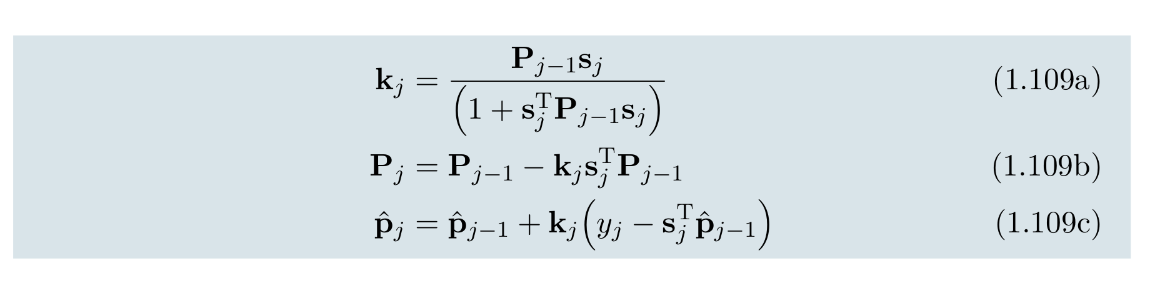

Die Ergebnisse des Verfahrens hängen maßgeblich von der Startmatrix P ab.   
Wahl der Startwerte:
$$
P_{0} = \alpha I
$$
Für große Werte von Alpha geht der RLS gegen den tatsächlichen Wert.

In [222]:
def rlse_online(s,y,x_old,P_old):
    """ Recursive Least Square Estimator

        Params
         --------
        s:             [y_k ... u_k ...]
        y:             time as int
        x:             Parameter vector  [a1, .... a2, b0, ....., bm ] der Länge m
        P:             inverser Messvektor (s.T@s)^-1
        
        Returns
        --------
        dx:       chance of the state as a vektor [qd1,qd2,qd3,qdd1,qdd2,qdd3,*,*,*,*]     
                
    """
    lamda = 1 #0.995                               # Vergessenheitsfaktor --> neue Messwerte werden stärker gewichtet          
    K = P_old@s / (lamda+s.T@P_old@s)       # Verstärkung für den neuen Schätzwert  --> K ist Vektor der Länge m
    x = x_old + K*(y-s.T@x_old)              # Update Parametervektor
    P = (P_old - K*s.T@P_old)/lamda           # Update Pseudoinverse Messmatrix
    return x,K,P




y = u_Stat.copy()
A = np.hstack([i_Stat,omega_Stat])


'''
# Initialisieren mit Startwerten
n = 2
P = np.eye(n,n)*1e+0
x = np.zeros((n))
print(x)
'''

daten = np.zeros((len(y),n))
Time  = np.zeros(len(y))

#Alternative wahl der Anfangsmatrixen mit Vorwissen
n = 2
A_init = A[0:n,:]
y_init = y[0:n]
P = np.linalg.inv(A_init.T@A_init)
#print(P)
x = P@A_init.T@y_init
x = x.flatten()
P = np.eye(n,n)*1e+0
#print(x)



import math
for k in range(len(y)):
    start = timer()
    daten[k,:] = x
    x,K,P = rlse_online(A[k,:],y[k,:],x,P)    
    Time[k] = timer()-start
    if math.isnan(x[0]):
        print(k)
        break 
    

print(x)


16000


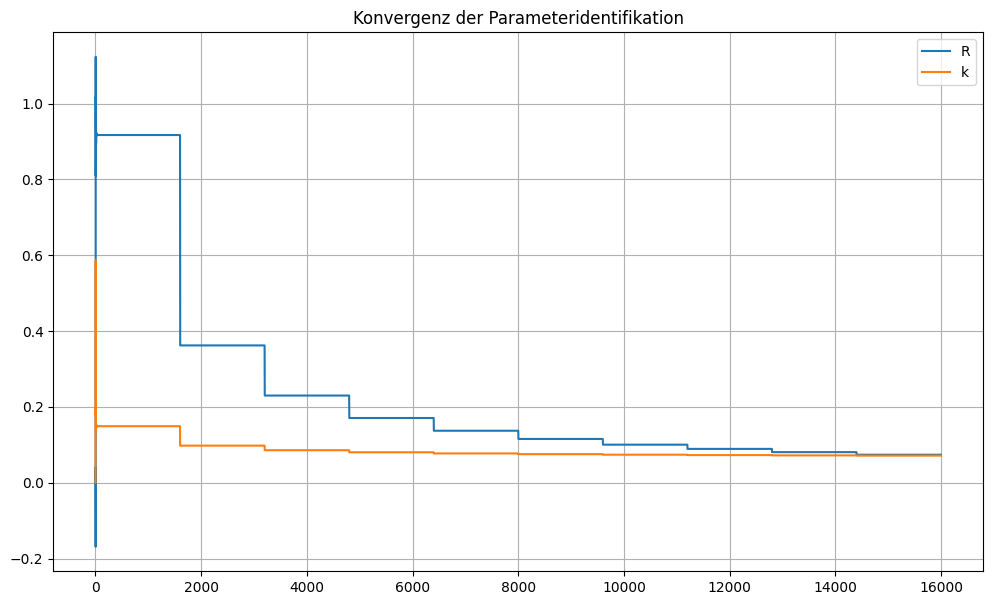

In [221]:
t=np.linspace(1,len(y),len(y))
print(len(t))

N = 16000

plt.figure(figsize=(12,7))
plt.plot(t[0:N],daten[0:N,0])
plt.plot(t[0:N],daten[0:N,1])
plt.grid(True)
plt.title('Konvergenz der Parameteridentifikation')
plt.legend(['R','k'])
plt.show()

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(t,Time)
plt.grid(True)
plt.title('Berechnungszeit für jeden Zyklus')
plt.show()

In [202]:
#recursive least squares --adam dhalla
import numpy as np 
import numpy.linalg 

class RecursiveLeastSquares():
    """Creates a RecursiveLeastSquares object, that will efficiently returned modified x's 
       as more data is inputted using the .addData() method. Updates to x are calculated using
       the Sherman-Morrison-Woodburry Formula. 
       - initA (Ndarray)
                the initial A matrix in least squares, before adding any data. The calculations 
                will be based off this initial matrix. Is size (examples, variables). Think of 
                the A matrix in the Normal Equations. 
       - initB (Ndarray)
               the initial "answers" B matrix. Same B in the Normal Equations. Size (examples, 1)
    """
    def __init__(self, initA, initb):
        self.A = initA  
        self.b = initb 

        # create the initial P matrix, the (A^T*A)^-1 matrix.
        # we don't link it to self.A, self.b since these will change, and after
        # the first P, we will use S-M-W to calculate P instead. 

        initialP = np.linalg.inv(np.dot(initA.transpose(), initA))
        self.P = initialP

        # do least squares automatically the first round 

        # self.K is the other part of the normal equation that multiplies P, (A^T)*B
        self.K = None

        # do least squares automatically for first time
        self.x = np.dot(initialP, np.dot(initA.transpose(), initb)) 
        #print(self.x)
        #print(self.K)
        #print(self.P)
    def addData(self, newA, newb):
        """add data to the least squares problems and returns an updated x.
           
           - newA    (ndarray)
                     adding more rows to the A matrix. Often a row vector (if adding one 
                     more data point). Otherwise, size is (newpoints, variables)
             
           - newb    (ndarray)
                     adds corresponding 'output' for the newA. A (1, 1) ndarray if adding
                     only one more data point. Else, size is (newpoints, 1)
            Returns the updated x. 
        """ 

        newA = newA.reshape(-1, (np.shape(newA)[0]))
        self.A = np.concatenate([self.A, newA])

        newb = newb.reshape(-1, 1)
        self.b = np.concatenate([self.b, newb])

        # create P by using Sherman-Morrison-Woodburry
        # I separate the formula into chunks for readability, see README for details

        # size of I depends on rows of data inputted
        I = (np.eye(np.shape(newA)[0]))


        PIn = np.linalg.inv(I + np.dot(newA, np.dot(self.P, newA.transpose())))
        PinA = np.dot(np.dot(newA.transpose(), PIn), newA)
        PinAP = np.dot(np.dot(self.P, PinA), self.P)
        P = self.P - PinAP

        # create K 
        self.P = P
        self.K = np.dot(self.P, newA.transpose())


        Q = newb - np.dot(newA, self.x)

        self.x = self.x + np.dot(self.K, Q)
        return self.x

In [209]:
b = u_Stat.copy()
A = np.hstack([i_Stat,omega_Stat])

rls = RecursiveLeastSquares(A[0:50,:], b[0:50]) 
x0 = rls.x



for k in range(len(b)):
    rls.addData(A[k,:], b[k])
x1 = rls.x

print(x1)

[[1.33635611]
 [0.06543783]]
